# Import packages

In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision


In [4]:
!pip install segmentation_models

     |████████████████████████████████| 50 kB 9.1 MB/s 


In [5]:
import segmentation_models as sm
sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [6]:
from segmentation_models.utils import set_trainable

In [7]:
import albumentations as A

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Mount drive

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Copy data

In [10]:
!cp -r '/content/drive/Shareddrives/fyp/dataset/segmented dataset/.' '/content/segmented dataset'

# Methods

In [11]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Unet

In [12]:
""" Global parameters """
H = 512
W = 512

In [13]:
BACKBONE = 'efficientnetb0'

In [14]:
def unet_model(input_shape):

    activation='softmax'

    
    # preprocess_input1 = sm.get_preprocessing(BACKBONE1)

    model = sm.Unet(backbone_name = BACKBONE,input_shape=input_shape, encoder_weights=None,  activation=activation)


    return model

In [15]:
def unet_fine_tune(input_shape):

    activation='softmax'

    
    # preprocess_input1 = sm.get_preprocessing(BACKBONE1)

    model = sm.Unet(backbone_name=BACKBONE,input_shape=input_shape, encoder_weights=None,  activation=activation, encoder_freeze=True)


    return model

In [16]:

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model




In [17]:
input_shape = (H, W, 3)
model = build_unet(input_shape)
# model = unet_model(input_shape)
# model = unet_fine_tune(input_shape)

In [18]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Load data

In [19]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path,"images" ,"*.*")))
    masks = sorted(glob(os.path.join(path, "masks", "*.*")))
    # print (len(images), len(masks))

    # split_size = int(len(images) * split)

    # train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    # train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    # train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    # train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return images, masks

In [20]:
dataset_path = "/content/segmented dataset/"

In [21]:
covid_images, covid_masks = load_data(dataset_path + "COVID/")
pneumonia_images, pneumonia_masks = load_data(dataset_path + "Pneumonia/")
normal_images, normal_masks = load_data(dataset_path + "Normal/")

In [22]:
len(covid_images)

439

In [23]:
len(pneumonia_images)

4250

In [24]:
len(normal_images)

1602

# Test train split

In [25]:
images = covid_images + pneumonia_images + normal_images
masks = covid_masks + pneumonia_masks + normal_masks

In [26]:
len(images)

6291

In [27]:
def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)


In [28]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    
    # Apply CLAHE
    lab = cv2.cvtColor(x, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
    lab[...,0] = clahe.apply(lab[...,0])
    x = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    x = x/255.0
    x = x.astype(np.float32)
    return x


In [29]:
img = read_image("/content/segmented dataset/Normal/images/1676193.jpg")

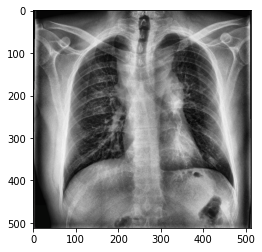

In [30]:

plt.imshow(img)
plt.show()

In [31]:
def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # x2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
    # x = x1 + x2
    x = cv2.resize(x, (W, H))
    
    x = x/np.max(x)
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [32]:
def tf_parse(x, y):
    def _parse(x, y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

In [33]:
def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset

In [35]:
batch_size = 5

In [34]:
def split_dataset(images, masks, split=0.1):
    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [36]:
""" Dataset """

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = split_dataset(images, masks, split=0.2)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)} ")
print(f"Test: {len(test_x)} - {len(test_y)} ")



Train: 3775 - 3775
Valid: 1258 - 1258 
Test: 1258 - 1258 


In [37]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [38]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

# Training

In [39]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)


In [40]:
""" Directory for storing files """
create_dir("files")

In [41]:
lr = 1e-5
num_epochs = 10
# num_epochs = 2
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "data.csv")

In [42]:
""" Model """
# model = unet_model((H, W, 3))
model = build_unet((H, W, 3))
# model = unet_fine_tune((H, W, 3))
metrics = [dice_coef, iou, Recall(), Precision()]
# model.compile(loss=sm.losses.JaccardLoss(), optimizer=Adam(lr), metrics=metrics)
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

In [43]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 512, 512, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                             

In [44]:
model_path = '/content/drive/Shareddrives/fyp/models/Unet/segmentation models/saved_models/10Epochs Lung Segmentation using UNET in TensorFlow 2.0.hdf5'

In [45]:
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    # CSVLogger(csv_path)
]

In [46]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [47]:
def show_test(dataset, num=1):
    """
    Displays the first image of each of the num batches
    """
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0]])

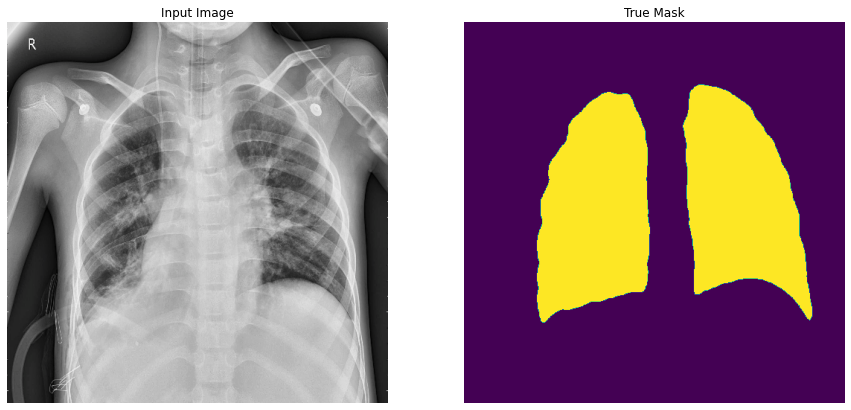

In [48]:
show_test(test_dataset)

In [49]:
model_history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/10
755/755 [==============================] - ETA: 0s - loss: 0.1663 - dice_coef: 0.8337 - iou: 0.7306 - recall: 0.9106 - precision: 0.8259
Epoch 00001: val_loss improved from inf to 0.09453, saving model to /content/drive/Shareddrives/fyp/models/Unet/segmentation models/saved_models/10Epochs Lung Segmentation using UNET in TensorFlow 2.0.hdf5
755/755 [==============================] - 1103s 1s/step - loss: 0.1663 - dice_coef: 0.8337 - iou: 0.7306 - recall: 0.9106 - precision: 0.8259 - val_loss: 0.0945 - val_dice_coef: 0.9055 - val_iou: 0.8279 - val_recall: 0.9243 - val_precision: 0.9381 - lr: 1.0000e-05
Epoch 2/10
755/755 [==============================] - 1081s 1s/step - loss: 0.0817 - dice_coef: 0.9183 - iou: 0.8494 - recall: 0.9424 - precision: 0.9357 - val_loss: 0.0756 - val_dice_coef: 0.9244 - val_iou: 0.8598 - val_recall: 0.9491 - val_precision: 0.9356 - lr: 1.0000e-05
Epoch 3/10
755/755 [==============================] - ETA: 0s - loss: 0.0705 - dice_coef: 0.9295 - iou:

In [65]:
model.save(model_path)

# Plot

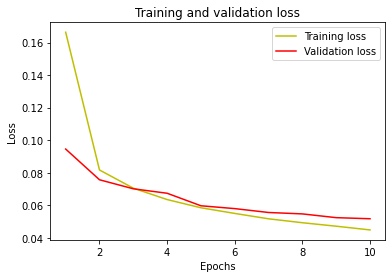

In [54]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

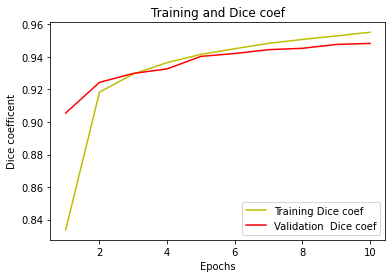

In [55]:
acc = model_history.history['dice_coef']
val_acc = model_history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice coef')
plt.plot(epochs, val_acc, 'r', label='Validation  Dice coef')
plt.title('Training and Dice coef')
plt.xlabel('Epochs')
plt.ylabel('Dice coefficent')
plt.legend()
plt.show()

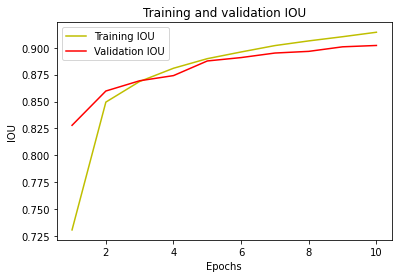

In [56]:
acc = model_history.history['iou']
val_acc = model_history.history['val_iou']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

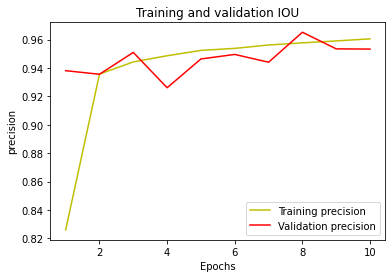

In [58]:
acc = model_history.history['precision']
val_acc = model_history.history['val_precision']

plt.plot(epochs, acc, 'y', label='Training precision')
plt.plot(epochs, val_acc, 'r', label='Validation precision')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()
plt.show()

# Evaluate

In [59]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope


In [60]:
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Evaluate
252/252 [==============================] - 115s 453ms/step - loss: 0.0516 - dice_coef: 0.9484 - iou: 0.9022 - recall: 0.9489 - precision: 0.9546


{'dice_coef': 0.9484426379203796,
 'iou': 0.9021996855735779,
 'loss': 0.05158127471804619,
 'precision': 0.9546120762825012,
 'recall': 0.9488604664802551}

In [61]:
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
      """ Extracing the image name. """
      image_name = x.split("/")[-1]

      """ Reading the image """
      ori_x = cv2.imread(x, cv2.IMREAD_COLOR)
      ori_x = cv2.resize(ori_x, (W, H))
      x = ori_x/255.0
      x = x.astype(np.float32)
      x = np.expand_dims(x, axis=0)

      """ Reading the mask """
      ori_y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
      ori_y = cv2.resize(ori_y, (W, H))
      ori_y = np.expand_dims(ori_y, axis=-1)  ## (512, 512, 1)
      ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)  ## (512, 512, 3)

      """ Predicting the mask. """
      y_pred = model.predict(x)[0] > 0.5
      y_pred = y_pred.astype(np.int32)

      """ Saving the predicted mask along with the image and GT """
      save_image_path = f"/content/files/{image_name}"
      y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

      sep_line = np.ones((H, 10, 3)) * 255

      cat_image = np.concatenate([ori_x, sep_line, ori_y, sep_line, y_pred*255], axis=1)
      cv2.imwrite(save_image_path, cat_image)

100%|██████████| 1258/1258 [04:00<00:00,  5.23it/s]


In [62]:
def create_mask(pred_mask):
    pred_mask = pred_mask.astype(np.int32)
    pred_mask = np.concatenate([pred_mask, pred_mask, pred_mask], axis=-1)
    return pred_mask * 255

In [63]:
def show_predictions(dataset, num=1):
    """
    Displays the first image of each of the num batches
    """
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)[0] > 0.5
      # print(pred_mask)
      display([image[0], mask[0], create_mask(pred_mask)])


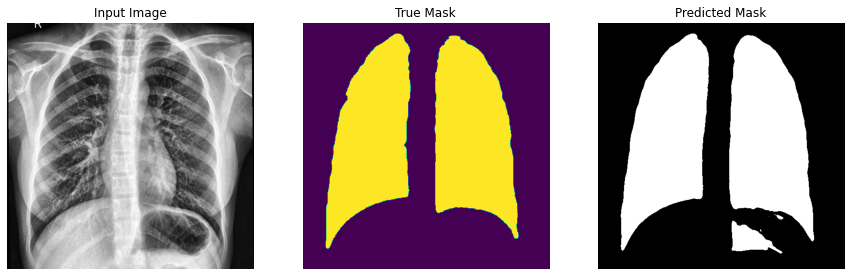

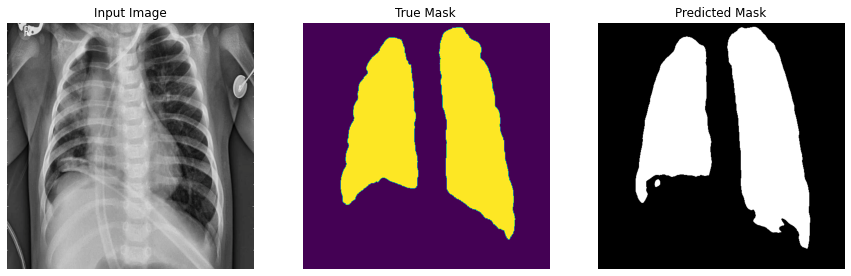

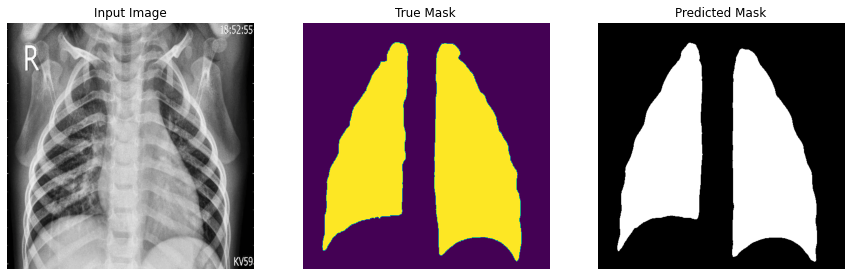

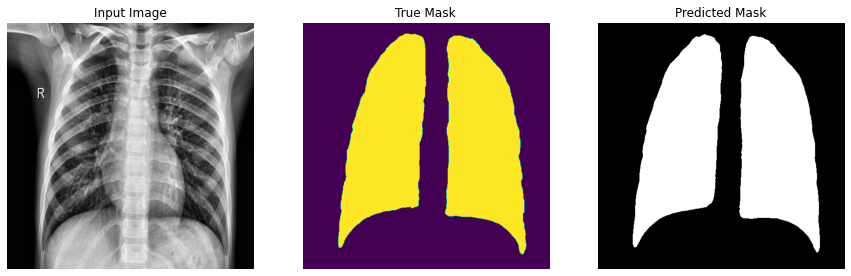

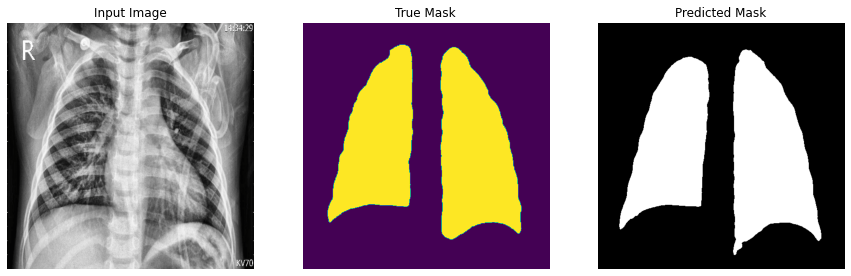

In [64]:
show_predictions(test_dataset, 5)